# Monitoramento de Risco de Ativos Digitais

## 1. Introdução

Este notebook realiza uma análise de risco e volatilidade para ativos digitais, comparando-os com ativos tradicionais como o índice S&P 500 e o Ouro (GC=F). 

### Metodologia
Os cálculos incluem:
- Retornos diários e acumulados.
- Volatilidade anualizada.
- Portfólio de pesos iguais e portfólio otimizado (Markowitz).
- Matriz de correlação para identificar relações entre os ativos.

O notebook também permite ao usuário escolher:
- Os ativos digitais para compor o portfólio.
- O período de análise: 1M (1 mês), 6M (6 meses), 1Y (1 ano), 3Y (3 anos) ou 5Y (5 anos).

### Objetivos
1. **Monitorar a volatilidade** dos ativos digitais escolhidos pelo usuário.
2. **Comparar os retornos acumulados** com ativos tradicionais (S&P 500 e Ouro).
3. **Criar portfólios otimizados** com base no método de Markowitz.
4. **Visualizar a correlação** entre os ativos digitais e os ativos tradicionais.

## 2. Importação de Bibliotecas

In [61]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.optimize import minimize
from datetime import datetime, timedelta

## 3. Configuração dos Ativos

In [62]:
ativos = {
    # Ativos Principais
    "S&P 500": "^GSPC",    
    "OURO": "GC=F",  

    # Ativos Digitais
    "Bitcoin": "BTC-USD",          
    "Ethereum": "ETH-USD",         
    "XRP": "XRP-USD",        
    "Tether": "USDT-USD",          
    "Solana": "SOL-USD",        
    "BNB": "BNB-USD",           
    "Dogecoin": "DOGE-USD",         
    "Cardano": "ADA-USD",     
    "Chainlink": "LINK-USD",   
    "Stellar": "XLM-USD", 
}

## 4. Definição de Funções

### Função para Determinar o Período

In [63]:
def definir_periodo(escolha):
    """Define o período de análise com base na escolha do usuário."""
    fim = datetime.now()
    
    if escolha.endswith("M"):  # Período em meses
        meses = int(escolha[:-1])
        if meses > 60:  # Limite de 60 meses (5 anos)
            raise ValueError("O período máximo permitido é de 60 meses (5 anos).")
        inicio = fim - timedelta(days=30 * meses)
    
    elif escolha.endswith("Y"):  # Período em anos
        anos = int(escolha[:-1])
        if anos > 5:  # Limite de 5 anos
            raise ValueError("O período máximo permitido é de 5 anos.")
        inicio = fim - timedelta(days=365 * anos)
    
    else:
        raise ValueError("Escolha inválida! Use '<n>M' para meses ou '<n>Y' para anos.")
    
    return inicio, fim

### Função para Baixar Dados

In [64]:
def baixar_dados(escolhas, periodo):
    inicio, fim = definir_periodo(periodo)
    ativos_selecionados = [ativos[ativo] for ativo in escolhas]
    dados = yf.download(ativos_selecionados, start=inicio, end=fim.strftime('%Y-%m-%d'))["Adj Close"]
    dados.columns = escolhas
    return dados.dropna()

## Funções para Calcular Carteiras

- Calcular Pesos Iguais

In [65]:
def calcular_pesos_iguais(retornos):
    """Calcula a carteira de pesos iguais e o retorno acumulado."""
    num_ativos = len(retornos.columns)
    pesos = np.array([1 / num_ativos] * num_ativos)
    retorno_carteira = (retornos @ pesos).cumsum()
    return pesos, retorno_carteira

- Calcular Carteira Otimizada (Markowitz)

In [66]:
def calcular_carteira_otimizada(retornos):
    """Calcula a carteira otimizada maximizando o índice de Sharpe."""
    cov_matrix = retornos.cov() * 252  # Matriz de covariância anualizada
    retorno_medio = retornos.mean() * 252  # Retornos médios anualizados
    num_ativos = len(retornos.columns)

    # Função objetivo: minimizar o negativo do índice de Sharpe
    def objetivo(pesos):
        retorno_portfolio = np.dot(pesos, retorno_medio)
        risco_portfolio = np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))
        sharpe_ratio = retorno_portfolio / risco_portfolio
        return -sharpe_ratio  # Maximizar Sharpe é equivalente a minimizar seu negativo

    # Restrições: os pesos somam 1
    restricao = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # Limites: cada peso entre 0% e 100%
    limites = tuple((0, 1) for _ in range(num_ativos))

    # Pesos iniciais: distribuição uniforme
    pesos_iniciais = np.array([1 / num_ativos] * num_ativos)

    # Otimização
    resultado = minimize(objetivo, pesos_iniciais, method="SLSQP", bounds=limites, constraints=restricao)
    
    # Pesos otimizados
    pesos = resultado.x

    # Calcular retorno acumulado da carteira com pesos otimizados
    retorno_carteira = (retornos @ pesos).cumsum()
    
    return pesos, retorno_carteira

### Funções de Visualização

- Gerar Matriz de Correlação

In [67]:
def gerar_matriz_correlacao(retornos):
    """Gera a matriz de correlação e a exibe como um heatmap."""
    correlacao = retornos.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlacao, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("Matriz de Correlação dos Ativos Selecionados")
    plt.show()
    return correlacao

- Gerar Gráfico de Retornos

In [78]:
def gerar_grafico(retorno_iguais, retorno_otimizado, retorno_sp500, retorno_ouro, periodo_escolhido):
    """Gera o gráfico de comparação de retornos acumulados com valores finais na legenda."""
    plt.figure(figsize=(14, 8))
    
    # Valores finais
    final_values = {
        "Carteira Otimizada": (retorno_otimizado.iloc[-1].item(), "green"),
        "Carteira Pesos Iguais": (retorno_iguais.iloc[-1].item(), "lightgreen"),
        "S&P 500": (retorno_sp500.iloc[-1].item(), "blue"),
        "Ouro": (retorno_ouro.iloc[-1].item(), "orange"),
    }

    # Plotar os retornos acumulados
    plt.plot(retorno_otimizado, label=f"Carteira Otimizada ({final_values['Carteira Otimizada'][0]:+.2%})", color="green")
    plt.plot(retorno_iguais, label=f"Carteira Pesos Iguais ({final_values['Carteira Pesos Iguais'][0]:+.2%})", color="lightgreen", linestyle="--")
    plt.plot(retorno_sp500, label=f"S&P 500 ({final_values['S&P 500'][0]:+.2%})", color="blue")
    plt.plot(retorno_ouro, label=f"Ouro ({final_values['Ouro'][0]:+.2%})", color="orange")
    
    # Linha no eixo zero
    plt.axhline(0, color="gray", linestyle="--", linewidth=1, alpha=0.8)
    
    # Configuração do eixo Y (em porcentagem)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    
    # Ajuste dinâmico do eixo X com base no período
    if periodo_escolhido.endswith("M"):
        meses = int(periodo_escolhido[:-1])
        if meses <= 12:  # Até 12 meses
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Marcação mensal
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
        elif meses <= 24:  # Entre 6 meses e 2 anos
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # A cada 3 meses
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        elif meses <= 36:  # Entre 2 anos e 3 anos
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # A cada 6 meses
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        else:  # Mais de 3 anos
            plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Marcação anual
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    elif periodo_escolhido.endswith("Y"):
        anos = int(periodo_escolhido[:-1])
        if anos == 1:  # Até 1 ano
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Marcação mensal
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        elif anos <= 2:  # Até 2 anos
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # A cada 3 meses
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        elif anos <= 3:  # Até 3 anos
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # A cada 6 meses
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        else:  # Mais de 3 anos
            plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Marcação anual
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Adicionar rótulos finais no gráfico
    for label, (value, color) in final_values.items():
        bbox_props = dict(
            boxstyle="round,pad=0.3", 
            edgecolor="none", 
            facecolor=color, 
            alpha=0.6
        )
        plt.text(retorno_otimizado.index[-1], value, f"{value:+.2%}",
                 fontsize=12, color="white", ha="left", va="center", bbox=bbox_props)

    # Configuração final do gráfico
    plt.title("Comparação de Retornos Acumulados")
    plt.xlabel("Período")
    plt.ylabel("Retorno Acumulado (%)")
    plt.legend(loc="upper left")  # Legenda movida para o canto superior esquerdo
    plt.grid()
    plt.show()

## 5. Escolha dos Ativos e Período 

In [85]:
# Simulação com escolhas do usuário
escolhas_usuario = ["Bitcoin", "Ethereum", "XRP", "Tether", "Solana", "Dogecoin", "Stellar"] # Exemplo de escolha do usuário
periodo_usuario = "15M" # Exemplo de escolha do período (1M a 60M ou 1Y a 5Y)

## 6. Execução do Cálculo e Visualização

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  2 of 2 completed


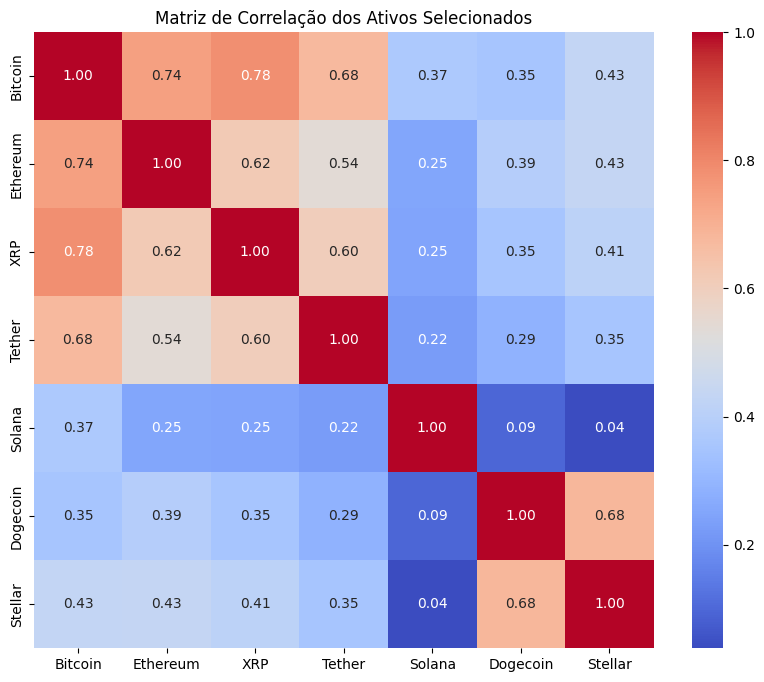

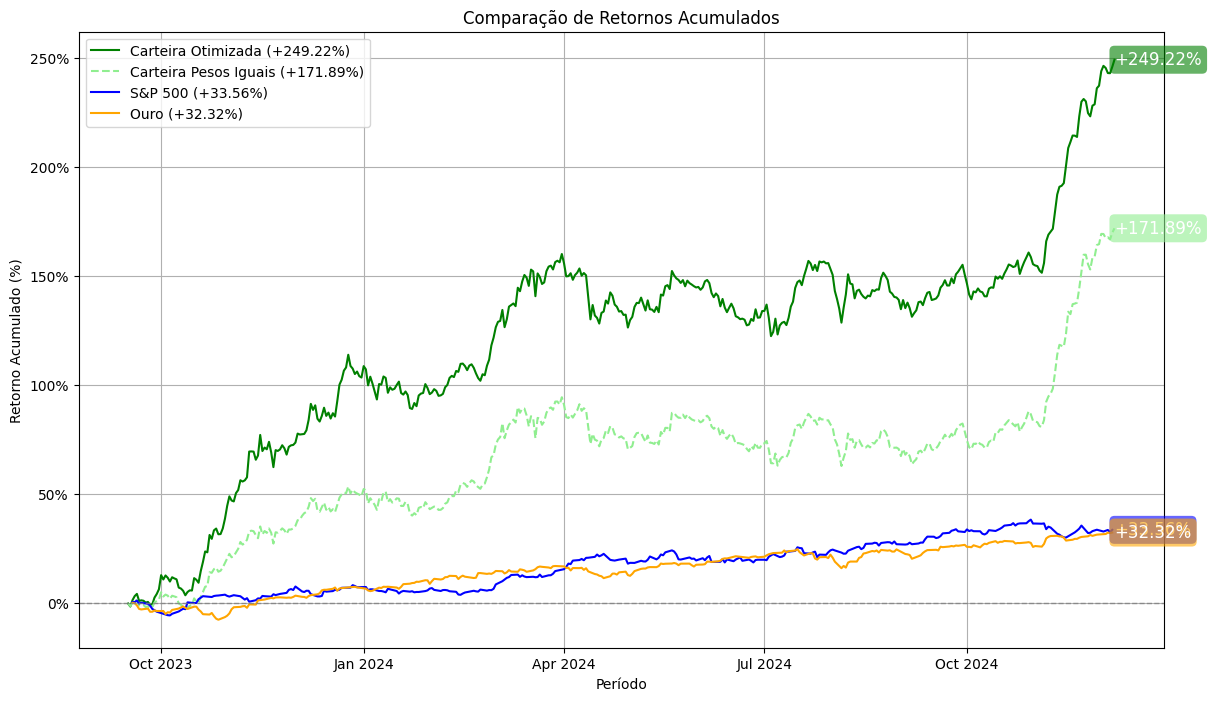


Pesos Iguais da Carteira:
Bitcoin: 14.29%
Ethereum: 14.29%
XRP: 14.29%
Tether: 14.29%
Solana: 14.29%
Dogecoin: 14.29%
Stellar: 14.29%

Pesos Otimizados da Carteira:
Bitcoin: 8.04%
Ethereum: 10.88%
XRP: 0.00%
Tether: 47.47%
Solana: 0.00%
Dogecoin: 2.23%
Stellar: 31.39%


In [86]:
# Baixar dados dos ativos escolhidos pelo usuário
dados_escolhidos = baixar_dados(escolhas_usuario, periodo_usuario)
retornos = dados_escolhidos.pct_change().dropna()

# Calcular retornos acumulados da carteira
pesos_iguais, retorno_iguais = calcular_pesos_iguais(retornos)
pesos_otimizados, retorno_otimizado = calcular_carteira_otimizada(retornos)

# Baixar dados dos benchmarks
dados_benchmarks = baixar_dados(["S&P 500", "OURO"], periodo_usuario)
retorno_sp500 = dados_benchmarks["S&P 500"].pct_change().dropna().cumsum()
retorno_ouro = dados_benchmarks["OURO"].pct_change().dropna().cumsum()

# Geração da Matriz de Correlação
correlacao = gerar_matriz_correlacao(retornos)

# Geração do Gráfico
gerar_grafico(retorno_iguais, retorno_otimizado, retorno_sp500, retorno_ouro, periodo_usuario)

# Exibir Pesos das Carteiras
print("\nPesos Iguais da Carteira:")
for ativo, peso in zip(escolhas_usuario, pesos_iguais):
    print(f"{ativo}: {peso:.2%}")

print("\nPesos Otimizados da Carteira:")
for ativo, peso in zip(escolhas_usuario, pesos_otimizados):
    print(f"{ativo}: {peso:.2%}")